In [22]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [23]:
ratings = pd.read_csv("data/RAW_interactions.csv")

In [24]:
print(ratings.shape)
ratings.head()

(1132367, 5)


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [25]:
ratings.dropna(inplace=True)

In [26]:
ratings["rating"].value_counts()

5    816229
4    187333
0     60847
3     40852
2     14122
1     12815
Name: rating, dtype: int64

In [27]:
ratings["rating"].value_counts(normalize=True)

5    0.720924
4    0.165460
0    0.053742
3    0.036082
2    0.012473
1    0.011319
Name: rating, dtype: float64

In [28]:
ratings = ratings[ratings['rating']!=0]
ratings.shape

(1071351, 5)

In [29]:
ratings.to_csv('cleaned_reviews.csv', index=False)

In [8]:
# Building Pipeline for raw text transformation
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('classifier', MultinomialNB(
                    fit_prior=True, class_prior=None)),
    ])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(ratings["review"]
                                                    , ratings["rating"],random_state = 42, 
                                                    stratify= ratings["rating"],
                                                   test_size = 0.20)

In [10]:
X_train.shape,X_test.shape,y_train.shape, y_test.shape

((857080,), (214271,), (857080,), (214271,))

In [11]:
model = clf.fit(X_train , y_train)

In [12]:
model.score(X_train,y_train)

0.7892833807812573

In [13]:
model.score(X_test,y_test)

0.7756439275496917

In [14]:
pred = model.predict(X_test)

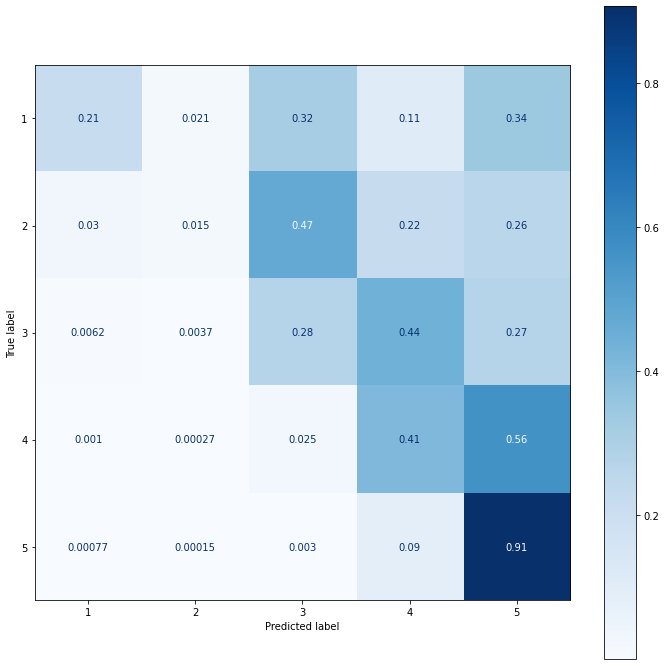

In [15]:
fig, ax = plt.subplots(figsize=(12, 12));
plot_confusion_matrix(model, X_test, y_test, cmap = 'Blues', normalize = 'true', ax=ax);

In [18]:
import time
# GradientBoost Model

model_pipeline = Pipeline([
    ("vec", TfidfVectorizer()),
    ("gb", GradientBoostingClassifier(random_state=42))
])

#the pipe params are a dict that the user enters into the function
model_pipe_params = {
    "gb__learning_rate" : [.05],
    "gb__n_estimators" : [100],
    "gb__min_samples_leaf" : [4],
    "gb__max_depth" : [4],
    'vec__max_features': [3000],
    'vec__min_df': [2],
    'vec__max_df': [.85],
    'vec__ngram_range': [(1,1)],
    'vec__stop_words': ["english"]
}

#start a timer
t0 = time.time()

gb_gs = GridSearchCV(model_pipeline,param_grid=model_pipe_params,cv=2,verbose=1)

#fit the data
gb_gs.fit(X_train,y_train)
t1 = time.time()
print(f'This took {t1-t0} seconds!')

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 138.6min finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'gb__learning_rate': [0.05], 'gb__max_depth': [4],
                         'gb__min_samples_leaf': [4], 'gb__n_estimators': [100],
                         'vec__max_df': [0.85], 'vec__max_features': [3000],
                         'vec__min_df': [2], 'vec__ngram_range': [(1, 1)],
                         'vec__stop_words': ['english']},
             verbose=1)

In [20]:
 #save the best estimator
best_gb = gb_gs.best_estimator_


print(f'best training score: {best_gb.score(X_train, y_train)}')
preds = best_gb.predict(X_train)
# print(f'best training recall: {recall_score(y_train,preds)}')
print(f'best testing score: {best_gb.score(X_test, y_test)}')

best training score: 0.7824707145190647
best testing score: 0.7811603063410354
This took 40907.965613126755 seconds!


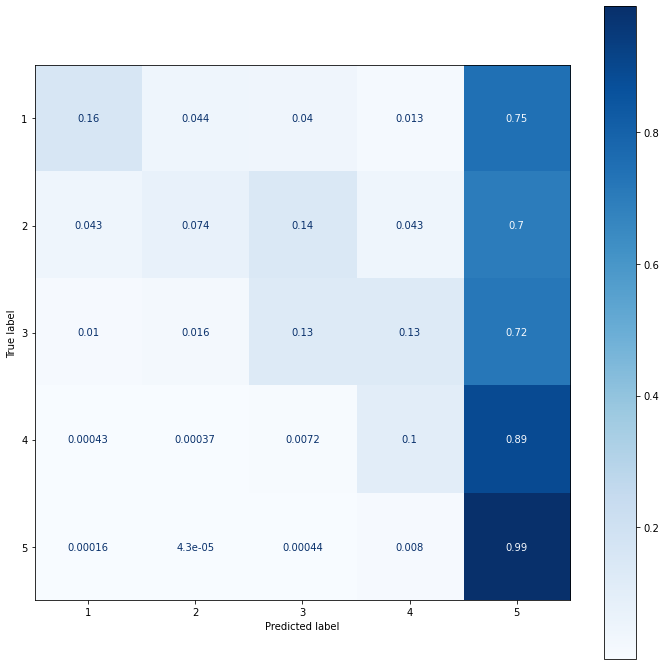

In [21]:
fig, ax = plt.subplots(figsize=(12, 12));
plot_confusion_matrix(best_gb, X_test, y_test, cmap = 'Blues', normalize = 'true', ax=ax);